In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from scipy.io import loadmat
%matplotlib inline

np.random.seed(2)
import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
import itertools
from keras.layers import Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input

from keras import utils as np_utils
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

from keras import regularizers
from sklearn.metrics import confusion_matrix
from scipy import misc

from keras.callbacks import TensorBoard

/home/sdc/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load data
data_path = "./data.mat"
data_raw = loadmat(data_path)

train_img = data_raw["train_img"]
test_img = data_raw["test_img"]
train_lbl = data_raw["train_lbl"]

## add noise

In [3]:
def saltpepper(trn_data): 
    # input is a n*28*28*1 numpy array, reshape each row to a 28*28 matrix
    row = trn_data.shape[0]
    for i in range(row):
        t = trn_data[i]
        t = t.reshape((28, 28))
        val = [1, 0]
        ver_idx = random.randint(4, 15)
        hor_idx = random.randint(4, 15)

        t[ver_idx:(ver_idx+10), hor_idx:(hor_idx+10)] = np.random.choice(val, size=(10, 10))
        
        t = t.reshape((28,28,1))
        trn_data[i] = t 
    return trn_data

noise_factor = 100/255
def gauss(trn_data):
    # input is a n*28*28*1 numpy array, reshape each row to a 28*28 matrix
    row = trn_data.shape[0]
    for i in range(row):
        t = trn_data[i]
        t = t.reshape((28, 28))
        t[4:24, 4:24] = t[4:24, 4:24] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=(20,20)) 

        t = t.reshape((28,28,1))
        trn_data[i] = t
    return trn_data

In [4]:
random_seed = 2

x_train_nor = np.reshape(train_img[0:20000], (len(train_img[0:20000]), 28, 28, 1))/255
x_train_sp = np.reshape(train_img[20000:50000], (len(train_img[20000:50000]), 28, 28, 1))/255
x_train_gs = np.reshape(train_img[20000:50000], (len(train_img[20000:50000]), 28, 28, 1))/255

ae_x_lbl = np.concatenate((x_train_nor, x_train_sp, x_train_gs)) # "labels" for auto encoder

ae_x_train_sp = saltpepper(x_train_sp)
ae_x_train_gs = np.clip(gauss(x_train_gs), 0., 1.)

ae_x_trn = np.concatenate((x_train_nor, ae_x_train_sp, ae_x_train_gs)) # "features" for auto encoder

print(ae_x_lbl.shape)
print(ae_x_trn.shape)

(80000, 28, 28, 1)
(80000, 28, 28, 1)


### Train Auto Encoder

In [5]:
#split data
ae_trn_X, ae_val_X, ae_trn_lb, ae_val_lb = train_test_split(ae_x_trn,
                                                             ae_x_lbl, 
                                                             test_size=0.1, 
                                                             random_state=13)

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(ae_trn_X, ae_trn_lb,
                epochs=80,
                batch_size=128,
                shuffle=True,
                validation_data=(ae_val_X, ae_val_lb),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])



Train on 72000 samples, validate on 8000 samples
Epoch 1/80
72000/72000 [==============================] - 6s 82us/step - loss: 0.1487 - val_loss: 0.1201
Epoch 2/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.1141 - val_loss: 0.1084
Epoch 3/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.1081 - val_loss: 0.1043
Epoch 4/80
72000/72000 [==============================] - 5s 73us/step - loss: 0.1047 - val_loss: 0.1048
Epoch 5/80
72000/72000 [==============================] - 5s 72us/step - loss: 0.1024 - val_loss: 0.1013
Epoch 6/80
72000/72000 [==============================] - 5s 68us/step - loss: 0.1007 - val_loss: 0.0990
Epoch 7/80
72000/72000 [==============================] - 5s 69us/step - loss: 0.0994 - val_loss: 0.0995
Epoch 8/80
72000/72000 [==============================] - 5s 72us/step - loss: 0.0984 - val_loss: 0.0972
Epoch 9/80
72000/72000 [==============================] - 5s 72us/step - loss: 0.0975 - val_loss: 0.0975
Epoch 

Epoch 78/80
72000/72000 [==============================] - 5s 68us/step - loss: 0.0872 - val_loss: 0.0879
Epoch 79/80
72000/72000 [==============================] - 5s 68us/step - loss: 0.0872 - val_loss: 0.0877
Epoch 80/80
72000/72000 [==============================] - 5s 68us/step - loss: 0.0872 - val_loss: 0.0882


### Test Auto Encoder on the Test Set

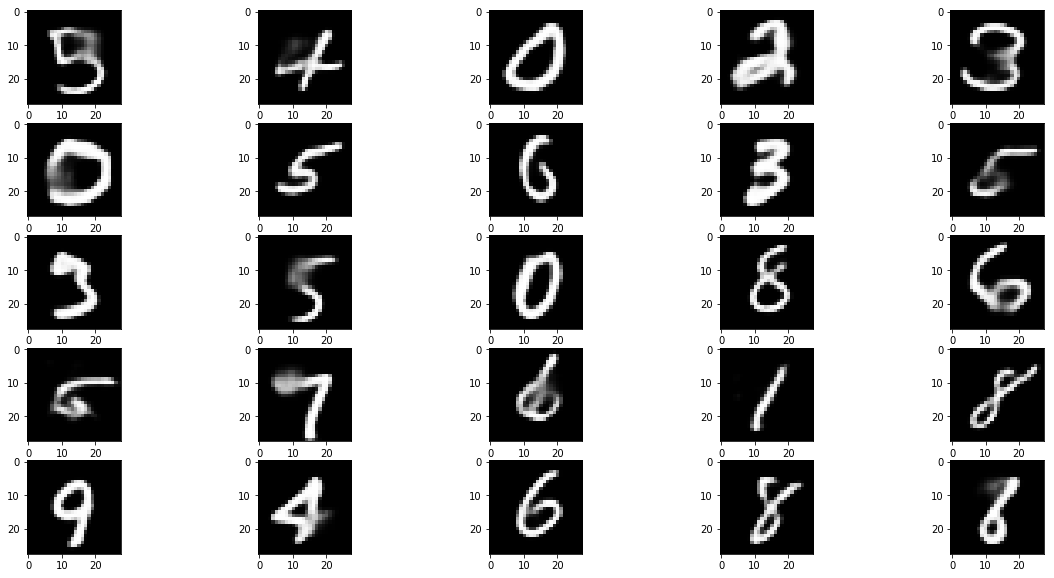

In [6]:
X_tst = np.reshape(test_img, (len(test_img), 28, 28, 1))/255 

clean_tst = autoencoder.predict(X_tst, batch_size=128)

length = clean_tst.shape[0]
result_tst = np.zeros(shape=(length, 784))
for i in range(length):
    result_tst[i,:] = result_tst[i,:] + clean_tst[i].reshape(1, 784)

result_viz = result_tst
plt.figure(figsize=(20,10))
for index, image in enumerate(result_viz[25:50]):
    plt.subplot(5, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

### KNN-Training Labels

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trn_nor = train_lbl[0:20000]
Y_trn_sp = train_lbl[20000:50000]
Y_trn_gs = train_lbl[20000:50000]

Y_trn_nor = np_utils.to_categorical(Y_trn_nor, num_classes = 10)
Y_trn_sp = np_utils.to_categorical(Y_trn_sp, num_classes = 10)
Y_trn_gs = np_utils.to_categorical(Y_trn_gs, num_classes = 10)

Y_trn_all = np.concatenate((Y_trn_nor, Y_trn_sp, Y_trn_gs))
Y_trn_all.shape

(80000, 10)

### KNN-Training Features

In [8]:
X_trn_all = autoencoder.predict(ae_x_trn, batch_size=128)
# X_tst is clean_tst
X_trn_all.shape

(80000, 28, 28, 1)

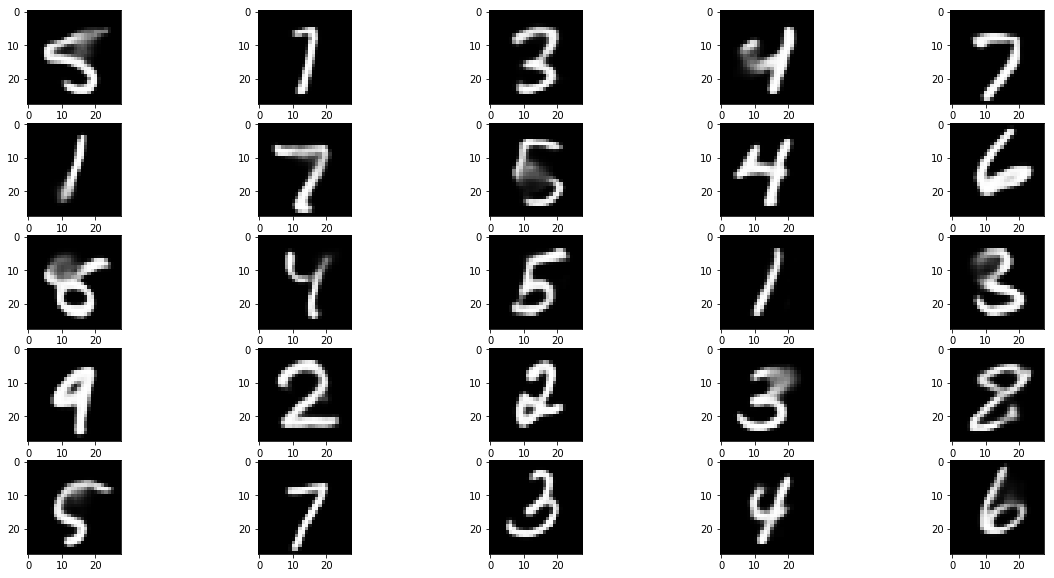

In [9]:
plt.figure(figsize=(20,10))
for index, image in enumerate(X_trn_all[random.sample(range(1, 60000), 25)]):
    plt.subplot(5, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)

## KNN

In [10]:
from collections import Counter

class simple_knn():

    def __init__(self):
        pass

    def train(self, X, Y):
        self.X_trn = X
        self.Y_trn = Y

    def predict(self, X, k=1):
        dists = self.compute_distances(X)

        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            k_closest_y = []
            labels = self.Y_trn[np.argsort(dists[i,:])].flatten()
            k_closest_y = labels[:k]

            c = Counter(k_closest_y)
            y_pred[i] = c.most_common(1)[0][0]

        return(y_pred)

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_trn.shape[0]

        dot_pro = np.dot(X, self.X_trn.T)
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.X_trn).sum(axis = 1)
        dists = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)

        return(dists)

### KNN - Run on Test

In [11]:
batch_size = 2000
k = 5
X_trn_KNN = np.reshape(X_trn_all, (len(X_trn_all), 784))
X_tst_KNN = np.reshape(clean_tst, (len(clean_tst), 784))
Y_trn_nor = train_lbl[0:20000]
Y_trn_sp = train_lbl[20000:50000]
Y_trn_gs = train_lbl[20000:50000]
Y_trn_KNN = np.concatenate((Y_trn_nor, Y_trn_sp, Y_trn_gs))

classifier = simple_knn()
classifier.train(X_trn_KNN, Y_trn_KNN)

predictions = []

for i in range(int(len(X_tst_KNN)/batch_size)):

    print("Computing batch " + str(i+1) + "/" + str(int(len(X_tst_KNN)/batch_size)) + "...")

    predts = classifier.predict(X_tst_KNN[i * batch_size:(i+1) * batch_size], k)

    predictions = predictions + list(predts)

print("Completed predicting the test data.")

Output = open("KNN.csv", "w")
Output.write("ID,Prediction\n")
for i in range(len(predictions)):
    Output.write(str(i+1) + "," + str(int(predictions[i])) + "\n")
Output.close()

Computing batch 1/10...
Computing batch 2/10...
Computing batch 3/10...
Computing batch 4/10...
Computing batch 5/10...
Computing batch 6/10...
Computing batch 7/10...
Computing batch 8/10...
Computing batch 9/10...
Computing batch 10/10...
Completed predicting the test data.


### KNN - Training Process

Computing batch 1/10...
Computing batch 2/10...
Computing batch 3/10...
Computing batch 4/10...
Computing batch 5/10...
Computing batch 6/10...
Computing batch 7/10...
Computing batch 8/10...
Computing batch 9/10...
Computing batch 10/10...
Completed predicting the test data.
Normalized confusion matrix
[[0.99119497 0.00125786 0.00377358 0.         0.         0.
  0.00251572 0.         0.00125786 0.        ]
 [0.         0.99546999 0.0011325  0.         0.00226501 0.
  0.0011325  0.         0.         0.        ]
 [0.00869565 0.00745342 0.95900621 0.00372671 0.00248447 0.
  0.00496894 0.00372671 0.00869565 0.00124224]
 [0.00119617 0.00837321 0.00598086 0.9437799  0.         0.01196172
  0.00239234 0.00358852 0.02033493 0.00239234]
 [0.         0.01790281 0.         0.         0.94373402 0.
  0.01150895 0.00383632 0.         0.0230179 ]
 [0.0027248  0.0013624  0.         0.02588556 0.0027248  0.93188011
  0.01634877 0.0027248  0.01089918 0.00544959]
 [0.         0.00249377 0.         0.

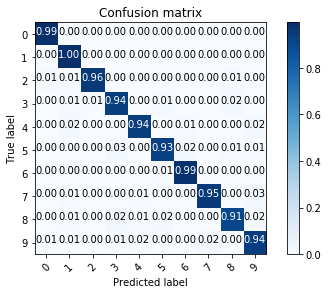

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X_trn_KNN, Y_trn_KNN, test_size = 0.1, random_state=random_seed)

batch_size = 800
k = 5
classifier = simple_knn()
classifier.train(X_train, Y_train)

trn_predict = []

for i in range(int(len(X_val)/batch_size)):

    print("Computing batch " + str(i+1) + "/" + str(int(len(X_val)/batch_size)) + "...")

    predts = classifier.predict(X_val[i * batch_size:(i+1) * batch_size], k)

    trn_predict = trn_predict + list(predts)

print("Completed predicting the test data.")

cnf_matrix = confusion_matrix(Y_val, trn_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,  classes=[0,1,2,3,4,5,6,7,8,9],normalize=True)

plt.show()